In [1]:
pip install requests pandas networkx plotly nbformat python-louvain



[notice] A new release of pip is available: 23.1.2 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade nbformat


[notice] A new release of pip is available: 23.1.2 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from itertools import combinations
from collections import Counter
import networkx as nx
import community.community_louvain as community


In [4]:
import requests
import pandas as pd

# Function to fetch and process data from OpenAlex
def fetch_openalex_data(concept_id, topic_label):
    url = "https://api.openalex.org/works"
    params = {
        'filter': f'concepts.id:{concept_id}',
        'per-page': 200
    }
    
    response = requests.get(url, params=params)
    data = response.json()
    
    works = data.get('results', [])
    extracted_data = []

    for work in works:
        year = work.get('publication_year', None)
        title = work.get('title', 'Unknown Title')
        authors = ', '.join(
            [author['author']['display_name'] for author in work.get('authorships', []) if author['author'].get('display_name')]
        )

        institutions = [auth.get('institutions', []) for auth in work.get('authorships', [])]
        
        # Extract institution names and countries safely
        institution_names = set()
        institution_countries = set()
        for inst_group in institutions:
            for inst in inst_group:
                if inst.get('display_name'):  # Avoid NoneType errors
                    institution_names.add(inst.get('display_name', 'Unknown Institution'))
                if inst.get('country_code'):  # Avoid NoneType errors
                    institution_countries.add(inst.get('country_code', 'Unknown Country'))
        
        citation_count = work.get('cited_by_count', 0)

        extracted_data.append({
            'Year': year,
            'Title': title,
            'Authors': authors,
            'Institution Name': ', '.join(institution_names) if institution_names else 'Unknown Institution',
            'Institution Country': ', '.join(institution_countries) if institution_countries else 'Unknown Country',
            'Citation Count': citation_count,
            'Topic': topic_label
        })
    
    return extracted_data

# Fetch data for each topic
ai_data = fetch_openalex_data('C154945302', 'Artificial Intelligence')
qt_data = fetch_openalex_data('C190463098', 'Quantum Technology')
eb_data = fetch_openalex_data('C136229726', 'Engineering Biology')

# Combine datasets
all_data = ai_data + qt_data + eb_data

# Convert to Pandas DataFrame
df = pd.DataFrame(all_data)

# Save to CSV for local use
df.to_csv("openalex_combined_dataset.csv", index=False)

# OR Save to Excel
# df.to_excel("openalex_combined_dataset.xlsx", index=False)

print("Dataset saved as 'openalex_combined_dataset.csv'")


Dataset saved as 'openalex_combined_dataset.csv'


In [5]:
print(df.columns)
print(df.info())
print(df.describe())


Index(['Year', 'Title', 'Authors', 'Institution Name', 'Institution Country',
       'Citation Count', 'Topic'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Year                 600 non-null    int64 
 1   Title                596 non-null    object
 2   Authors              600 non-null    object
 3   Institution Name     600 non-null    object
 4   Institution Country  600 non-null    object
 5   Citation Count       600 non-null    int64 
 6   Topic                600 non-null    object
dtypes: int64(2), object(5)
memory usage: 32.9+ KB
None
              Year  Citation Count
count   600.000000      600.000000
mean   2004.008333    11059.725000
std      12.268216    16928.862783
min    1930.000000      494.000000
25%    1999.750000     1278.750000
50%    2006.500000     2206.000000
75%    2012.000000 

In [6]:
# Count unique articles
print("Unique Articles:", df['Title'].nunique())

# Count unique authors (splitting by comma and exploding into separate rows)
print("Unique Authors:", df['Authors'].str.split(', ').explode().nunique())

# Count unique countries (using the correct column name 'Institutional Country')
print("Unique Countries:", df['Institution Country'].str.split(', ').explode().nunique())

# Count unique institutions (using the correct column name 'Institution Name')
print("Unique Institutions:", df['Institution Name'].str.split(', ').explode().nunique())


Unique Articles: 585
Unique Authors: 2070
Unique Countries: 42
Unique Institutions: 595


In [7]:
# Get the top 10 most frequent authors
top_authors = df['Authors'].str.split(', ').explode().value_counts().head(10)
print("Top 10 Authors:\n", top_authors)

# Get the top 10 most frequent institutions (using the correct column name 'Institution Name')
top_institutions = df['Institution Name'].str.split(', ').explode().value_counts().head(10)
print("Top 10 Institutions:\n", top_institutions)

# Get the top 10 most frequent university countries (using the correct column name 'Institutional Country')
top_countries = df['Institution Country'].str.split(', ').explode().value_counts().head(10)
print("Top 10 University Countries:\n", top_countries)


Top 10 Authors:
 Authors
Geoffrey E. Hinton    8
Mikhail D. Lukin      8
Ross Girshick         7
Jörg Wrachtrup        7
Fedor Jelezko         7
C. Monroe             7
S. M. Girvin          6
Róbert Langer         6
David Mooney          6
Kaiming He            6
Name: count, dtype: int64
Top 10 Institutions:
 Institution Name
Unknown Institution                             68
Harvard University                              36
Massachusetts Institute of Technology           36
University of California                        29
University of Michigan–Ann Arbor                26
Stanford University                             19
California Institute of Technology              16
Centre National de la Recherche Scientifique    15
University of Oxford                            13
Google (United States)                          13
Name: count, dtype: int64
Top 10 University Countries:
 Institution Country
US                 322
GB                  72
DE                  71
Unknown Country

In [8]:
# Filter for rows with "Unknown Institution"
unknown_institutions = df[df['Institution Name'].str.contains("Unknown Institution", na=False)]
print(f"Rows with 'Unknown Institution':\n{unknown_institutions}")

# Filter for rows with "Unknown Country"
unknown_countries = df[df['Institution Country'].str.contains("Unknown Country", na=False)]
print(f"Rows with 'Unknown Country':\n{unknown_countries}")


Rows with 'Unknown Institution':
     Year                                              Title  \
14   2017                          Attention Is All You Need   
19   1989  Genetic algorithms in search, optimization, an...   
20   1996                                         Fuzzy sets   
28   2003  Model Selection and Multimodel Inference: A Pr...   
32   1994  Situated Learning: Legitimate Peripheral Parti...   
..    ...                                                ...   
496  1983  Method for analysis of cellular DNA content of...   
503  1981  Calcium Phosphate Ceramics as Hard Tissue Pros...   
522  2014                   Principles of Tissue Engineering   
571  2006                                 Advanced Materials   
590  2001  Osteoinduction, osteoconduction and osseointeg...   

                                               Authors     Institution Name  \
14   Ashish Vaswani, Noam Shazeer, Niki Parmar, Jak...  Unknown Institution   
19                                      

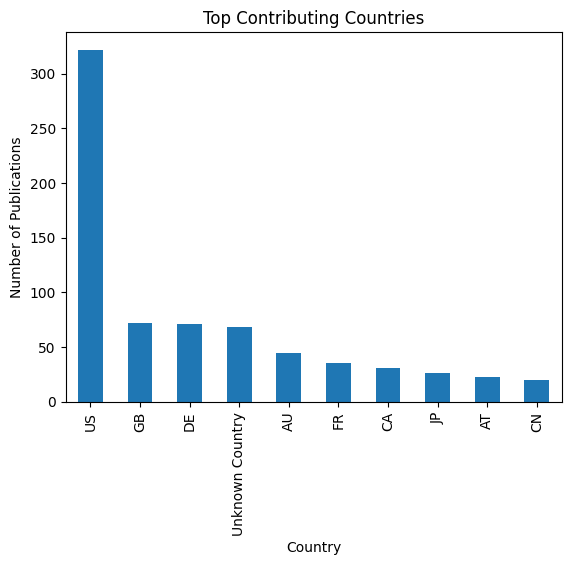

In [9]:
#countries
top_countries = df['Institution Country'].str.split(', ').explode().value_counts().head(10)
top_countries.plot(kind='bar')
plt.title("Top Contributing Countries")
plt.xlabel("Country")
plt.ylabel("Number of Publications")
plt.show()


In [10]:
from itertools import combinations
from collections import Counter

# Initialize a list to hold country-to-country pairs
country_pairs = []

# Loop through each row in the dataframe
for countries in df['Institution Country']:
    if pd.notna(countries):  # Ensure countries are not missing
        # Split the countries and filter out "Unknown Country"
        country_list = list(set(countries.split(', ')))
        country_list = [country for country in country_list if country != "Unknown Country"]
        
        # Generate all possible pairs of countries
        country_pairs += list(combinations(country_list, 2))

# Count the occurrences of each country pair
pair_counts = Counter(country_pairs)

# Get the top 10 most frequent country collaborations
top_country_pairs = dict(sorted(pair_counts.items(), key=lambda x: x[1], reverse=True)[:10])

# Print the top country-to-country collaborations
print("Top Country-to-Country Collaborations:\n", top_country_pairs)



Top Country-to-Country Collaborations:
 {('US', 'DE'): 24, ('US', 'GB'): 23, ('US', 'AU'): 15, ('US', 'CA'): 10, ('US', 'JP'): 10, ('GB', 'DE'): 9, ('CA', 'DE'): 8, ('FR', 'US'): 8, ('US', 'CN'): 8, ('AU', 'GB'): 7}


In [11]:
# Check if any "Unknown Country" or "Unknown Institution" remains
print("Rows with 'Unknown Country':", df['Institution Country'].str.contains("Unknown Country").sum())
print("Rows with 'Unknown Institution':", df['Institution Name'].str.contains("Unknown Institution").sum())


Rows with 'Unknown Country': 68
Rows with 'Unknown Institution': 68


In [12]:
from itertools import combinations
from collections import Counter

# Filter out rows containing "Unknown Country" or "Unknown Institution"
filtered_df = df[
    ~df['Institution Country'].str.contains("Unknown Country", na=False) &
    ~df['Institution Name'].str.contains("Unknown Institution", na=False)
]

# Initialize a list to hold country-to-country pairs
country_pairs = []

# Loop through each row in the filtered dataframe
for countries in filtered_df['Institution Country']:
    if pd.notna(countries):  # Ensure countries are not missing
        # Get a unique list of countries for the row
        country_list = list(set(countries.split(', ')))
        
        # Generate all possible pairs of countries
        country_pairs += list(combinations(country_list, 2))

# Count the occurrences of each country pair
pair_counts = Counter(country_pairs)

# Get the top 10 most frequent country collaborations
top_country_pairs = dict(sorted(pair_counts.items(), key=lambda x: x[1], reverse=True)[:10])

# Print the top country-to-country collaborations
print("Top Country-to-Country Collaborations:\n", top_country_pairs)


Top Country-to-Country Collaborations:
 {('US', 'DE'): 24, ('US', 'GB'): 23, ('US', 'AU'): 15, ('US', 'CA'): 10, ('US', 'JP'): 10, ('GB', 'DE'): 9, ('CA', 'DE'): 8, ('FR', 'US'): 8, ('US', 'CN'): 8, ('AU', 'GB'): 7}


In [13]:
# Check if any "Unknown Country" or "Unknown Institution" remains
print("Rows with 'Unknown Country':", filtered_df['Institution Country'].str.contains("Unknown Country").sum())
print("Rows with 'Unknown Institution':", filtered_df['Institution Name'].str.contains("Unknown Institution").sum())


Rows with 'Unknown Country': 0
Rows with 'Unknown Institution': 0


In [14]:
print(filtered_df.nunique)
print(filtered_df.info())

<bound method DataFrame.nunique of      Year                                              Title  \
0    2016       Deep Residual Learning for Image Recognition   
1    2001                                               None   
2    1995  Controlling the False Discovery Rate: A Practi...   
3    1990                  Basic local alignment search tool   
4    1997  Gapped BLAST and PSI-BLAST: a new generation o...   
..    ...                                                ...   
595  2005  Optical properties of human skin, subcutaneous...   
596  1999   Porous chitosan scaffolds for tissue engineering   
597  2004              Susceptibility weighted imaging (SWI)   
598  2015  Three-dimensional printing of complex biologic...   
599  2008  Extracellular matrix as a biological scaffold ...   

                                               Authors  \
0    Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun   
1                                          Leo Breiman   
2                     

In [15]:
missing_titles = filtered_df['Title'].isna().sum()
print(f"Number of missing Titles: {missing_titles}")

Number of missing Titles: 3


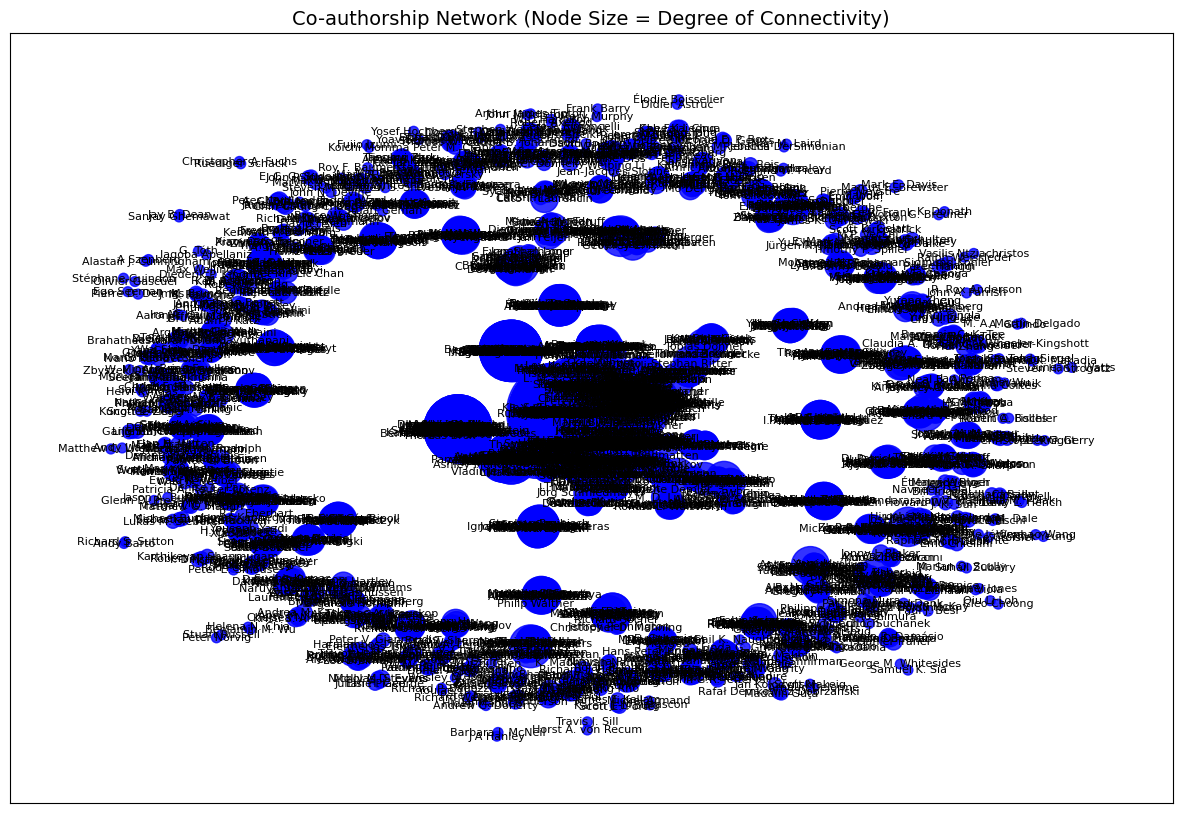

In [16]:
import networkx as nx
import matplotlib.pyplot as plt

# Initialize the graph
G = nx.Graph()

# Add edges based on co-authorship
for _, row in df.iterrows():
    if pd.notna(row['Authors']):  # Ensure authors column is not empty
        authors = list(set(row['Authors'].split(', ')))  # Ensure unique authors per row
        # Add edges for each pair of co-authors
        for author1, author2 in combinations(authors, 2):
            if G.has_edge(author1, author2):
                G[author1][author2]['weight'] += 1  # Increment weight for repeated collaborations
            else:
                G.add_edge(author1, author2, weight=1)

# Calculate node degrees (connectivity)
degree = dict(G.degree())
node_size = [v * 50 for v in degree.values()]  # Scale by degree (adjust scaling as needed)

# Layout for visualization
pos = nx.spring_layout(G, seed=42)  # Use spring layout for clear visualization

# Draw the network
plt.figure(figsize=(15, 10))
nx.draw_networkx_nodes(G, pos, node_size=node_size, alpha=0.8, node_color="blue")
nx.draw_networkx_edges(G, pos, alpha=0.4, edge_color="gray")
nx.draw_networkx_labels(G, pos, font_size=8)

# Add title
plt.title("Co-authorship Network (Node Size = Degree of Connectivity)", fontsize=14)
plt.show()


Number of Nodes (Authors): 1989
Number of Edges (Collaborations): 12316

Top 10 Authors by Degree Centrality:
V. B. Braginsky: 0.0503
D. Barker: 0.0493
I. Bartos: 0.0493
M. R. Abernathy: 0.0493
R. Biswas: 0.0493
J. Abadie: 0.0493
D. Amariutei: 0.0493
A. Bertolini: 0.0493
M. Born: 0.0493
M. Benacquista: 0.0493

Number of Communities Detected: 264
Largest Community Size: 136


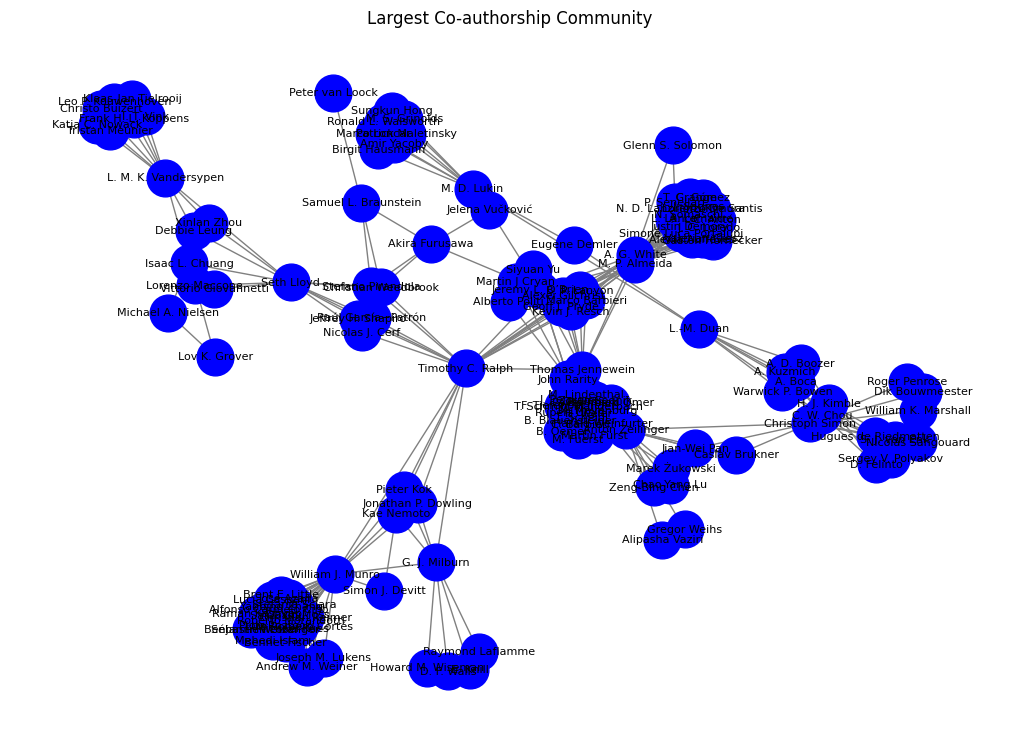

In [17]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import community

#basic information 
print("Number of Nodes (Authors):", G.number_of_nodes())
print("Number of Edges (Collaborations):", G.number_of_edges())

#want top 10 authors
degree_centrality = nx.degree_centrality(G)
top_authors = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

print("\nTop 10 Authors by Degree Centrality:")
for author, score in top_authors:
    print(f"{author}: {score:.4f}")

#should detect largest community
communities = list(community.greedy_modularity_communities(G))
print(f"\nNumber of Communities Detected: {len(communities)}")

#identify the largest community
largest_community = max(communities, key=len)
print(f"Largest Community Size: {len(largest_community)}")

#visualize the largest community
H = G.subgraph(largest_community)  #want the largest community
pos = nx.spring_layout(H, seed=42)  #subgraph visualization

plt.figure(figsize=(10, 7))
nx.draw(
    H, pos, with_labels=True, node_size=700, node_color="blue", edge_color="gray", font_size=8
)
plt.title("Largest Co-authorship Community")
plt.show()


In [18]:
pip install dash


[notice] A new release of pip is available: 23.1.2 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [19]:
import networkx as nx
import pandas as pd
from dash import Dash, dcc, html, Input, Output
import plotly.graph_objects as go

G = nx.Graph()

#add edges with topic as an attribute
for _, row in df.iterrows():
    if pd.notna(row['Authors']) and pd.notna(row['Topic']):
        authors = list(set(row['Authors'].split(', ')))
        for author1, author2 in combinations(authors, 2):
            if G.has_edge(author1, author2):
                G[author1][author2]['weight'] += 1
                G[author1][author2]['topics'].add(row['Topic'])
            else:
                G.add_edge(author1, author2, weight=1, topics={row['Topic']})

#need the visualisation to be interactive
app = Dash(__name__)

#define app
app.layout = html.Div([
    html.H1("Co-authorship Network by Topic"),
    dcc.Dropdown(
        id="topic-filter",
        options=[
            {"label": "Artificial Intelligence", "value": "Artificial Intelligence"},
            {"label": "Engineering Biology", "value": "Engineering Biology"},
            {"label": "Quantum Technology", "value": "Quantum Technology"}
        ],
        value="Artificial Intelligence",
        clearable=False
    ),
    dcc.Graph(id="network-graph")
])

#this should loop in selected topic to make a filter? 
@app.callback(
    Output("network-graph", "figure"),
    Input("topic-filter", "value")
)
def update_graph(selected_topic):
    #this should work for selected topic
    filtered_edges = [
        (u, v) for u, v, d in G.edges(data=True) if selected_topic in d['topics']
    ]
    
    #subgraph
    subgraph = G.edge_subgraph(filtered_edges)

    #documentation talks about spring layout. will this work? 
    pos = nx.spring_layout(subgraph, seed=42)
    
    #enter plotly
    edge_x = []
    edge_y = []
    for edge in subgraph.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])

    node_x = []
    node_y = []
    node_size = []
    node_text = []
    for node in subgraph.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_size.append(5 + 2 * G.degree(node))  #scale?
        node_text.append(node)

    #create edge trace
    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color="#888"),
        hoverinfo="none",
        mode="lines"
    )

    #create node trace
    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode="markers+text",
        text=node_text,
        marker=dict(
            size=node_size,
            color="blue",
            line_width=2
        )
    )

    #finger crossed. this should combine.
    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title=f"Co-authorship Network - {selected_topic}",
                        showlegend=False,
                        hovermode="closest",
                        margin=dict(b=0, l=0, r=0, t=40),
                        xaxis=dict(showgrid=False, zeroline=False),
                        yaxis=dict(showgrid=False, zeroline=False)
                    ))
    return fig

# Run the Dash app
if __name__ == "__main__":
    app.run_server(debug=True)


In [25]:
from itertools import combinations
from collections import Counter
import networkx as nx
import pandas as pd
from dash import Dash, dcc, html, Input, Output
import plotly.graph_objects as go

# Initialize the Dash app
app = Dash(__name__)

# Layout of the app
app.layout = html.Div([
    html.H1("Country Collaboration Network by Topic and Year"),
    
    # Dropdown for topic filter
    dcc.Dropdown(
        id="topic-filter",
        options=[
            {"label": "Artificial Intelligence", "value": "Artificial Intelligence"},
            {"label": "Engineering Biology", "value": "Engineering Biology"},
            {"label": "Quantum Technology", "value": "Quantum Technology"}
        ],
        value="Artificial Intelligence",
        clearable=False
    ),
    
    # Slider for year filter
    dcc.RangeSlider(
        id="year-slider",
        min=1993,
        max=2023,
        step=1,
        value=[1993, 2023],
        marks={year: str(year) for year in range(1993, 2024, 5)}  # Marks every 5 years
    ),
    
    # Graph for visualization
    dcc.Graph(id="country-network-graph")
])

# Callback to update the graph based on topic and year range
@app.callback(
    Output("country-network-graph", "figure"),
    [Input("topic-filter", "value"), Input("year-slider", "value")]
)
def update_country_graph(selected_topic, selected_years):
    # Filter dataframe by topic and year range
    filtered_df = df[
        (df['Topic'] == selected_topic) & 
        (df['Year'] >= selected_years[0]) & 
        (df['Year'] <= selected_years[1])
    ]

    # Extract country pairs
    country_edges = []
    for _, row in filtered_df.iterrows():
        countries = list(set(row['Institution Country'].split(', ')))
        country_edges += list(combinations(countries, 2))
    
    # Count collaborations by country
    country_pairs = Counter(country_edges)

    # Build the country graph
    G_country = nx.Graph()
    for pair, weight in country_pairs.items():
        G_country.add_edge(pair[0], pair[1], weight=weight)

    # Generate positions for visualization
    pos_country = nx.spring_layout(G_country, seed=42)

    # Build the Plotly figure
    edge_x = []
    edge_y = []
    for edge in G_country.edges():
        x0, y0 = pos_country[edge[0]]
        x1, y1 = pos_country[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])

    node_x = []
    node_y = []
    node_size = []
    node_text = []
    for node in G_country.nodes():
        x, y = pos_country[node]
        node_x.append(x)
        node_y.append(y)
        node_size.append(10 + 3 * G_country.degree(node))  # Scale node size by degree
        collaborations = sum(d['weight'] for _, _, d in G_country.edges(node, data=True))
        node_text.append(f"{node}<br>Collaborations: {collaborations}<br>Degree: {G_country.degree(node)}")

    # Create edge trace
    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color="gray"),
        hoverinfo="none",
        mode="lines"
    )

    # Create node trace
    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode="markers",
        marker=dict(
            size=node_size,
            color="blue",
            line_width=2
        ),
        hoverinfo="text",
        text=node_text  # Tooltip text with detailed information
    )

    # Combine into a figure
    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title=f"Country Collaboration Network - {selected_topic} ({selected_years[0]}-{selected_years[1]})",
                        showlegend=False,
                        hovermode="closest",
                        margin=dict(b=0, l=0, r=0, t=40),
                        xaxis=dict(showgrid=False, zeroline=False),
                        yaxis=dict(showgrid=False, zeroline=False)
                    ))
    return fig

# Run the Dash app
if __name__ == "__main__":
    app.run_server(debug=True)




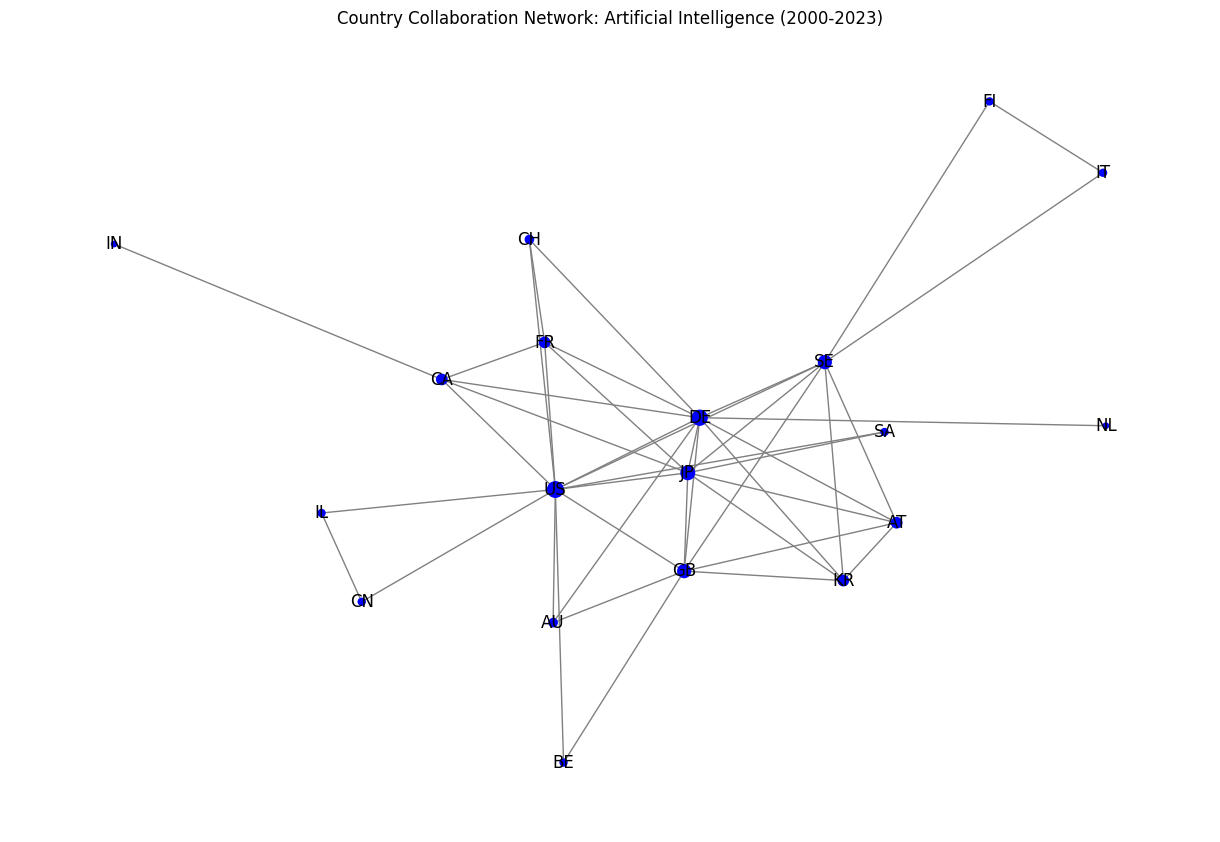

In [23]:
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
from collections import Counter

# User-defined filters
selected_topic = "Artificial Intelligence"  # Example: Topic filter
selected_year_range = (2000, 2023)  # Example: Year range filter

# Filter the dataframe
filtered_df = df[
    (df['Topic'] == selected_topic) & 
    (df['Year'] >= selected_year_range[0]) & 
    (df['Year'] <= selected_year_range[1])
]

# Extract country pairs
country_edges = []
for _, row in filtered_df.iterrows():
    countries = list(set(row['Institutional Country'].split(', ')))
    country_edges += list(combinations(countries, 2))

# Count collaborations by country
country_pairs = Counter(country_edges)

# Build the country graph
G_country = nx.Graph()
for pair, weight in country_pairs.items():
    G_country.add_edge(pair[0], pair[1], weight=weight)

# Generate positions for visualization
pos_country = nx.spring_layout(G_country, seed=42)

# Plot the graph
plt.figure(figsize=(12, 8))
nx.draw(
    G_country, pos_country, 
    with_labels=True, 
    node_size=[5 + 10 * G_country.degree(node) for node in G_country.nodes()],  # Scale nodes by degree
    node_color="blue", 
    edge_color="gray"
)
plt.title(f"Country Collaboration Network: {selected_topic} ({selected_year_range[0]}-{selected_year_range[1]})")
plt.show()
